## Setup environment

In this notebook we will set up a deconvolution environment, get test images and test that dependencies installed properly.

Note the hollow bars test image found in this example was developed by the Biomedical Imaging Group at EPFL and can be found [here](http://bigwww.epfl.ch/deconvolution/bars/).

Deconvolution napari is an extension of developmental biology napari but requires a couple of experimental libraries.

We could just add these to the devbio-napari environment but it's good practice to install experimental libraries in a new environment. 

So first use mamba to create a new environment based on devbio-napari

```
mamba create --name deconvolution-napari-env python=3.9 devbio-napari pyqt -c conda-forge -c pytorch
```

Now install cuda and cupy.  

Note: You can probably use a version different than 11, just make sure cudatookkit and cupy versions are compatible.

```
mamba install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
pip install cupy-cuda11x
```

Now let's install the tnia-python library (for projections and some helper functions), clij2-fft (for deconvolution), stardist (for measuring segmentation quality and for an example comparing classical deconvolution to deep learning deconvolution) and psfmodels (for diffractions based PSFs). 

```
pip install git+https://github.com/True-North-Intelligent-Algorithms/tnia-python
pip install --index-url https://test.pypi.org/simple/ --no-deps clij2-fft
pip install psfmodels
```

(in case of errors with clij2-fft try) 

```
pip install --index-url https://test.pypi.org/simple/ --no-deps clij2-fft==0.19
```

And for an example showing how to simulate images for deconvolution testing (and deep learning training)

```
pip install raster-geometry
```

Mac-users may also need to install this:

    conda install -c conda-forge ocl_icd_wrapper_apple

Linux users may also need to install this:

    conda install -c conda-forge ocl-icd-system


## Test imports

Now test whether the above have been installed properly

In [12]:
try:
    import imnotthere as int
    imnothtere_found=True
    print('ImNotThere found')
except ImportError:
    imnotthere_found=False
    print('!ImNotThere NOT found')

try:
    from clij2fft.richardson_lucy import richardson_lucy_nc
    clij2_rl_found=True
    print('clij2fft found')
except ImportError:
    clij2_rl_found=False
    print('!clij2fft NOT found')
    
try:
    import RedLionfishDeconv as rl
    redlionfish_rl_found=True
    print('RLF found')
except ImportError:
    redlionfish_rl_found=False
    print('!RLF NOT found')
    
try:
    import cupy as cp
    cupy_found=True
    print('cupy found')
except ImportError:
    cupy_found=False
    print('!cupy NOT found')
    
import numpy as np
    

tnia available
stackview available
!ImNotThere NOT found
clij2fft found
RLF found
cupy found


## Get and open test images

1.  Get images from this link https://cloudstore.zih.tu-dresden.de/index.php/s/gHgFZnMtfAwNpEk
2.  Beside the ```PoL-BioImage-Analysis-TS-GPU-Accelerated-Image-Analysis``` folder create an images folder and place the deconvolution folder inside of it.
2.  In the code snippet below change ```im_path``` to the local location on your machine where you put the above folder
3.  Use imread to verify you can open the image, then print the size of the image and verify it is is ```(128,256,256)```


In [13]:
from skimage.io import imread
from decon_helper import image_path

image_name='Bars-G10-P30-stack.tif'
psf_name='PSF-Bars-stack.tif'
truth_name='Bars-stack.tif'

im=imread(image_path / image_name)
psf=imread(image_path / psf_name)
truth=imread(image_path / truth_name)
im=im.astype('float32')
psf=psf.astype('float32')
psf=psf/psf.sum()
print(im.shape, psf.shape, truth.shape)

(128, 256, 256) (128, 256, 256) (128, 256, 256)


## View 3D Data in notebook

View the data using xy, xz, and zy max projections.  

In [14]:
import decon_helper
decon_helper.test_helper()

decon_helper.show_xyz_slice(im)
#import stackview
#help(stackview.orthogonal(im, continuous_update=Tru)

Hello from decon_helper.py
tnia available:  True
stackview available:  True


In [15]:
#stackview.orthogonal(im, continuous_update=True)
decon_helper.show_xyz_slice(im)
decon_helper.show_xyz_slice(psf)
decon_helper.show_xyz_slice(truth)


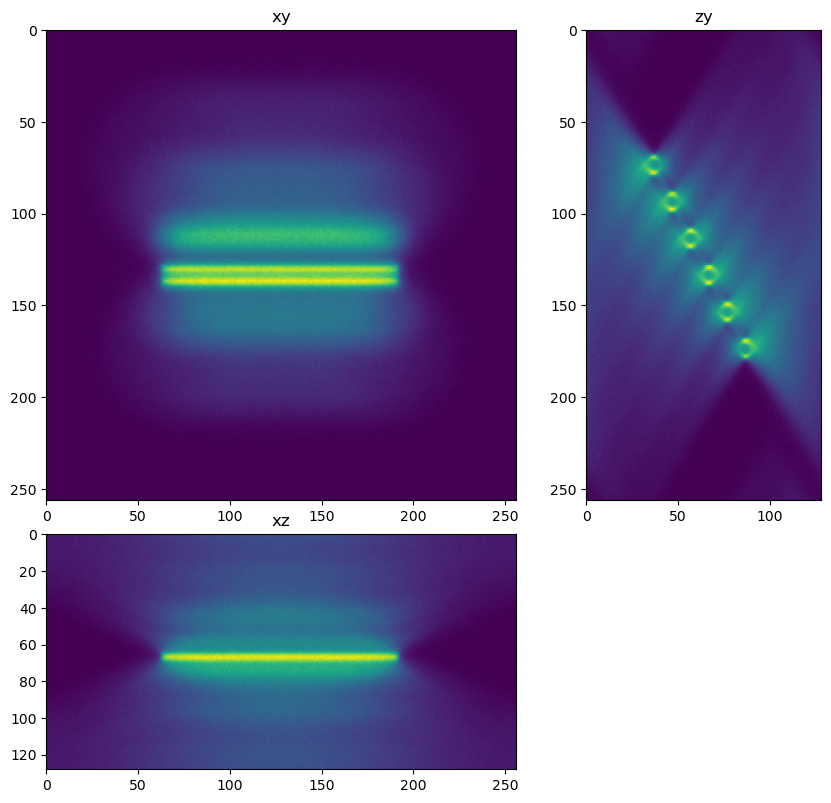

In [16]:
decon_helper.show_xyz_slice(im, 'tnia')

## Import deconvolution libraries

Try imnporting the clij2 and redlionfish implementations of Richardson Lucy.  If they are found perform a deconvolution with each library

In [17]:
try:
    from clij2fft.richardson_lucy import richardson_lucy_nc
    clij2_rl_found=True
    
except ImportError:
    clij2_rl_found=False
try:
    import RedLionfishDeconv as rl
    redlionfish_rl_found=True
except ImportError:
    redlionfish_rl_found=False
    
print('clij2 rl found',clij2_rl_found)
print('redlionfish rl found',redlionfish_rl_found)    

clij2 rl found True
redlionfish rl found True


In [20]:
if clij2_rl_found==True:
    decon_clij2=richardson_lucy_nc(im,psf,100,0)
    decon_helper.show_xyz_slice(decon_clij2,'tnia')
else:
    print('clij2 not found')
    decon_clij2=np.zeros_like(im)

clij2 not found


In [21]:
decon_helper.show_xyz_slice(decon_clij2)

In [22]:
if redlionfish_rl_found==True:
    decon_rlf=rl.doRLDeconvolutionFromNpArrays(im, psf, niter=100, method='gpu', resAsUint8=False )
else:
    print('redlionfish not found')
    decon_rlf=np.zeros_like(im)

In [23]:
decon_helper.show_xyz_slice(decon_rlf, 'tnia')

## View data in Napari and ask questions

View the data in Napari, switch to a 3D view and rotate and explore the dataset?  How good is the reconstruction?  Is it a truer representation of the data as compared to the image?  

Excercise: Deconvolve the data for 1000 iterations, or 10,000 if you have a fast GPU (or even 100,000 if you have a fast GPU and a bit of time).  Does the reconstruction continue to improve with more iterations?

In [24]:
import napari
viewer=napari.Viewer()
viewer.add_image(im)
viewer.add_image(decon_clij2)
viewer.add_image(decon_rlf)
viewer.add_image(truth)

<Image layer 'truth' at 0x7f438f22bfa0>